# Data Science research Methods Report-2

## **Introduction**<br>
The PAMAP2 Physical Activity Monitoring dataset (available here) contains data from 9 participants who participated in 18 various physical activities (such as walking, cycling, and soccer) while wearing three inertial measurement units (IMUs) and a heart rate monitor. This information is saved in separate text files for each subject. The goal is to build hardware and/or software that can determine the amount and type of physical activity performed by an individual by using insights derived from analysing the given dataset. 

%%HTML<br>
<style type="text/css"><br>
table.dataframe td, table.dataframe th {<br>
    border: 1px  black solid !important;<br>
  color: black !important;<br>
}<br>
</style>

In [97]:
import os
from IPython.display import display
from matplotlib import rcParams
from scipy.stats import ranksums
import numpy as np
import seaborn as sns
os.chdir("/home/sahil/Downloads/PAMAP2_Dataset/Protocol")
import pandas as pd
import matplotlib.pyplot as plt

## Data Cleaning<br>
For tidying up the data :<br>
- We load the data of various subjects and give relevant column names<br>
  for various features. <br>
- The data for all subjects are then stacked together to form one table.<br>
- We remove the 'Orientation' columns because it was mentioned <br>
  in the data report that it is invalid in this data collection.<br>
- Similarly, the rows with Activity ID "0" are also removed as<br>
  it does not relate to any specific activity.<br>
- The missing values are filled up using the mean for that feature.


<br>
Given below are functions to give relevant names to the columns and create a<br>
single table containing data for all subjects<br>


In [98]:
def gen_activity_names():
    # Using this function all the activity names are mapped to their ids
    act_name = {}
    act_name[0] = 'transient'
    act_name[1] = 'lying'
    act_name[2] = 'sitting'
    act_name[3] = 'standing'
    act_name[4] = 'walking'
    act_name[5] = 'running'
    act_name[6] = 'cycling'
    act_name[7] = 'Nordic_walking'
    act_name[9] = 'watching_TV'
    act_name[10] = 'computer_work'
    act_name[11] = 'car driving'
    act_name[12] = 'ascending_stairs'
    act_name[13] = 'descending_stairs'
    act_name[16] = 'vacuum_cleaning'
    act_name[17] = 'ironing'
    act_name[18] = 'folding_laundry'
    act_name[19] = 'house_cleaning'
    act_name[20] = 'playing_soccer'
    act_name[24] = 'rope_jumping'
    return act_name
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]
def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]
def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output
def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
def load_subjects(root='/home/sahil/Downloads/PAMAP2_Dataset/Protocol/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110,2):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output
data = load_subjects()# Add your own location for the data here to replicate the code
# for eg data = load_subjects('filepath')
data = data.drop(data[data['activity_id']==0].index)# Removing rows with activity id of 0
act = gen_activity_names()
data['activity_name'] = data.activity_id.apply(lambda x:act[x])
data = data.drop([i for i in data.columns if 'orientation' in i],axis=1)# Dropping Orientation 
# columns
display(data.head())

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,id,activity_name
2928,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,101,lying
2929,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,101,lying
2930,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,101,lying
2931,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,101,lying
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101,lying


**Note**: The procedure to replace missing values using the feature mean is performed<br>
after hypothesis testing and EDA as filling up the missing values would lead to us getting<br>
incorrect sample sizes for hypotheses testing.For Hypotheses testing the blank rows of an <br>
attribute will simply be ignored.

In [99]:
def clean_data(data): # Function for extracting clean data
    #data = data.interpolate()
    # fill all the NaN values in a column with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    return data

## Exploratory Data Analysis<br>
After labeling the data appropriately, it is randomly split into training and testing sets. <br>
In the training set, we perform Exploratory Data Analysis and come up with potential hypotheses. <br>
We then test those hypotheses on the testing set.<br>
50% of data is used for training in this case(Exploratory data analysis) and the rest for testing

In [100]:
def train_test_split(data,split_size):
    np.random.seed(5)
    msk = np.random.rand(len(data)) < split_size # This code implies 80% of the values will be True
    train = data[msk] # Generating training data
    test = data[~msk] # generating testing data  
    return train,test
train,test = train_test_split(data,0.50)

### Data Visualizations

* Boxplot of heart rate grouped by activity 

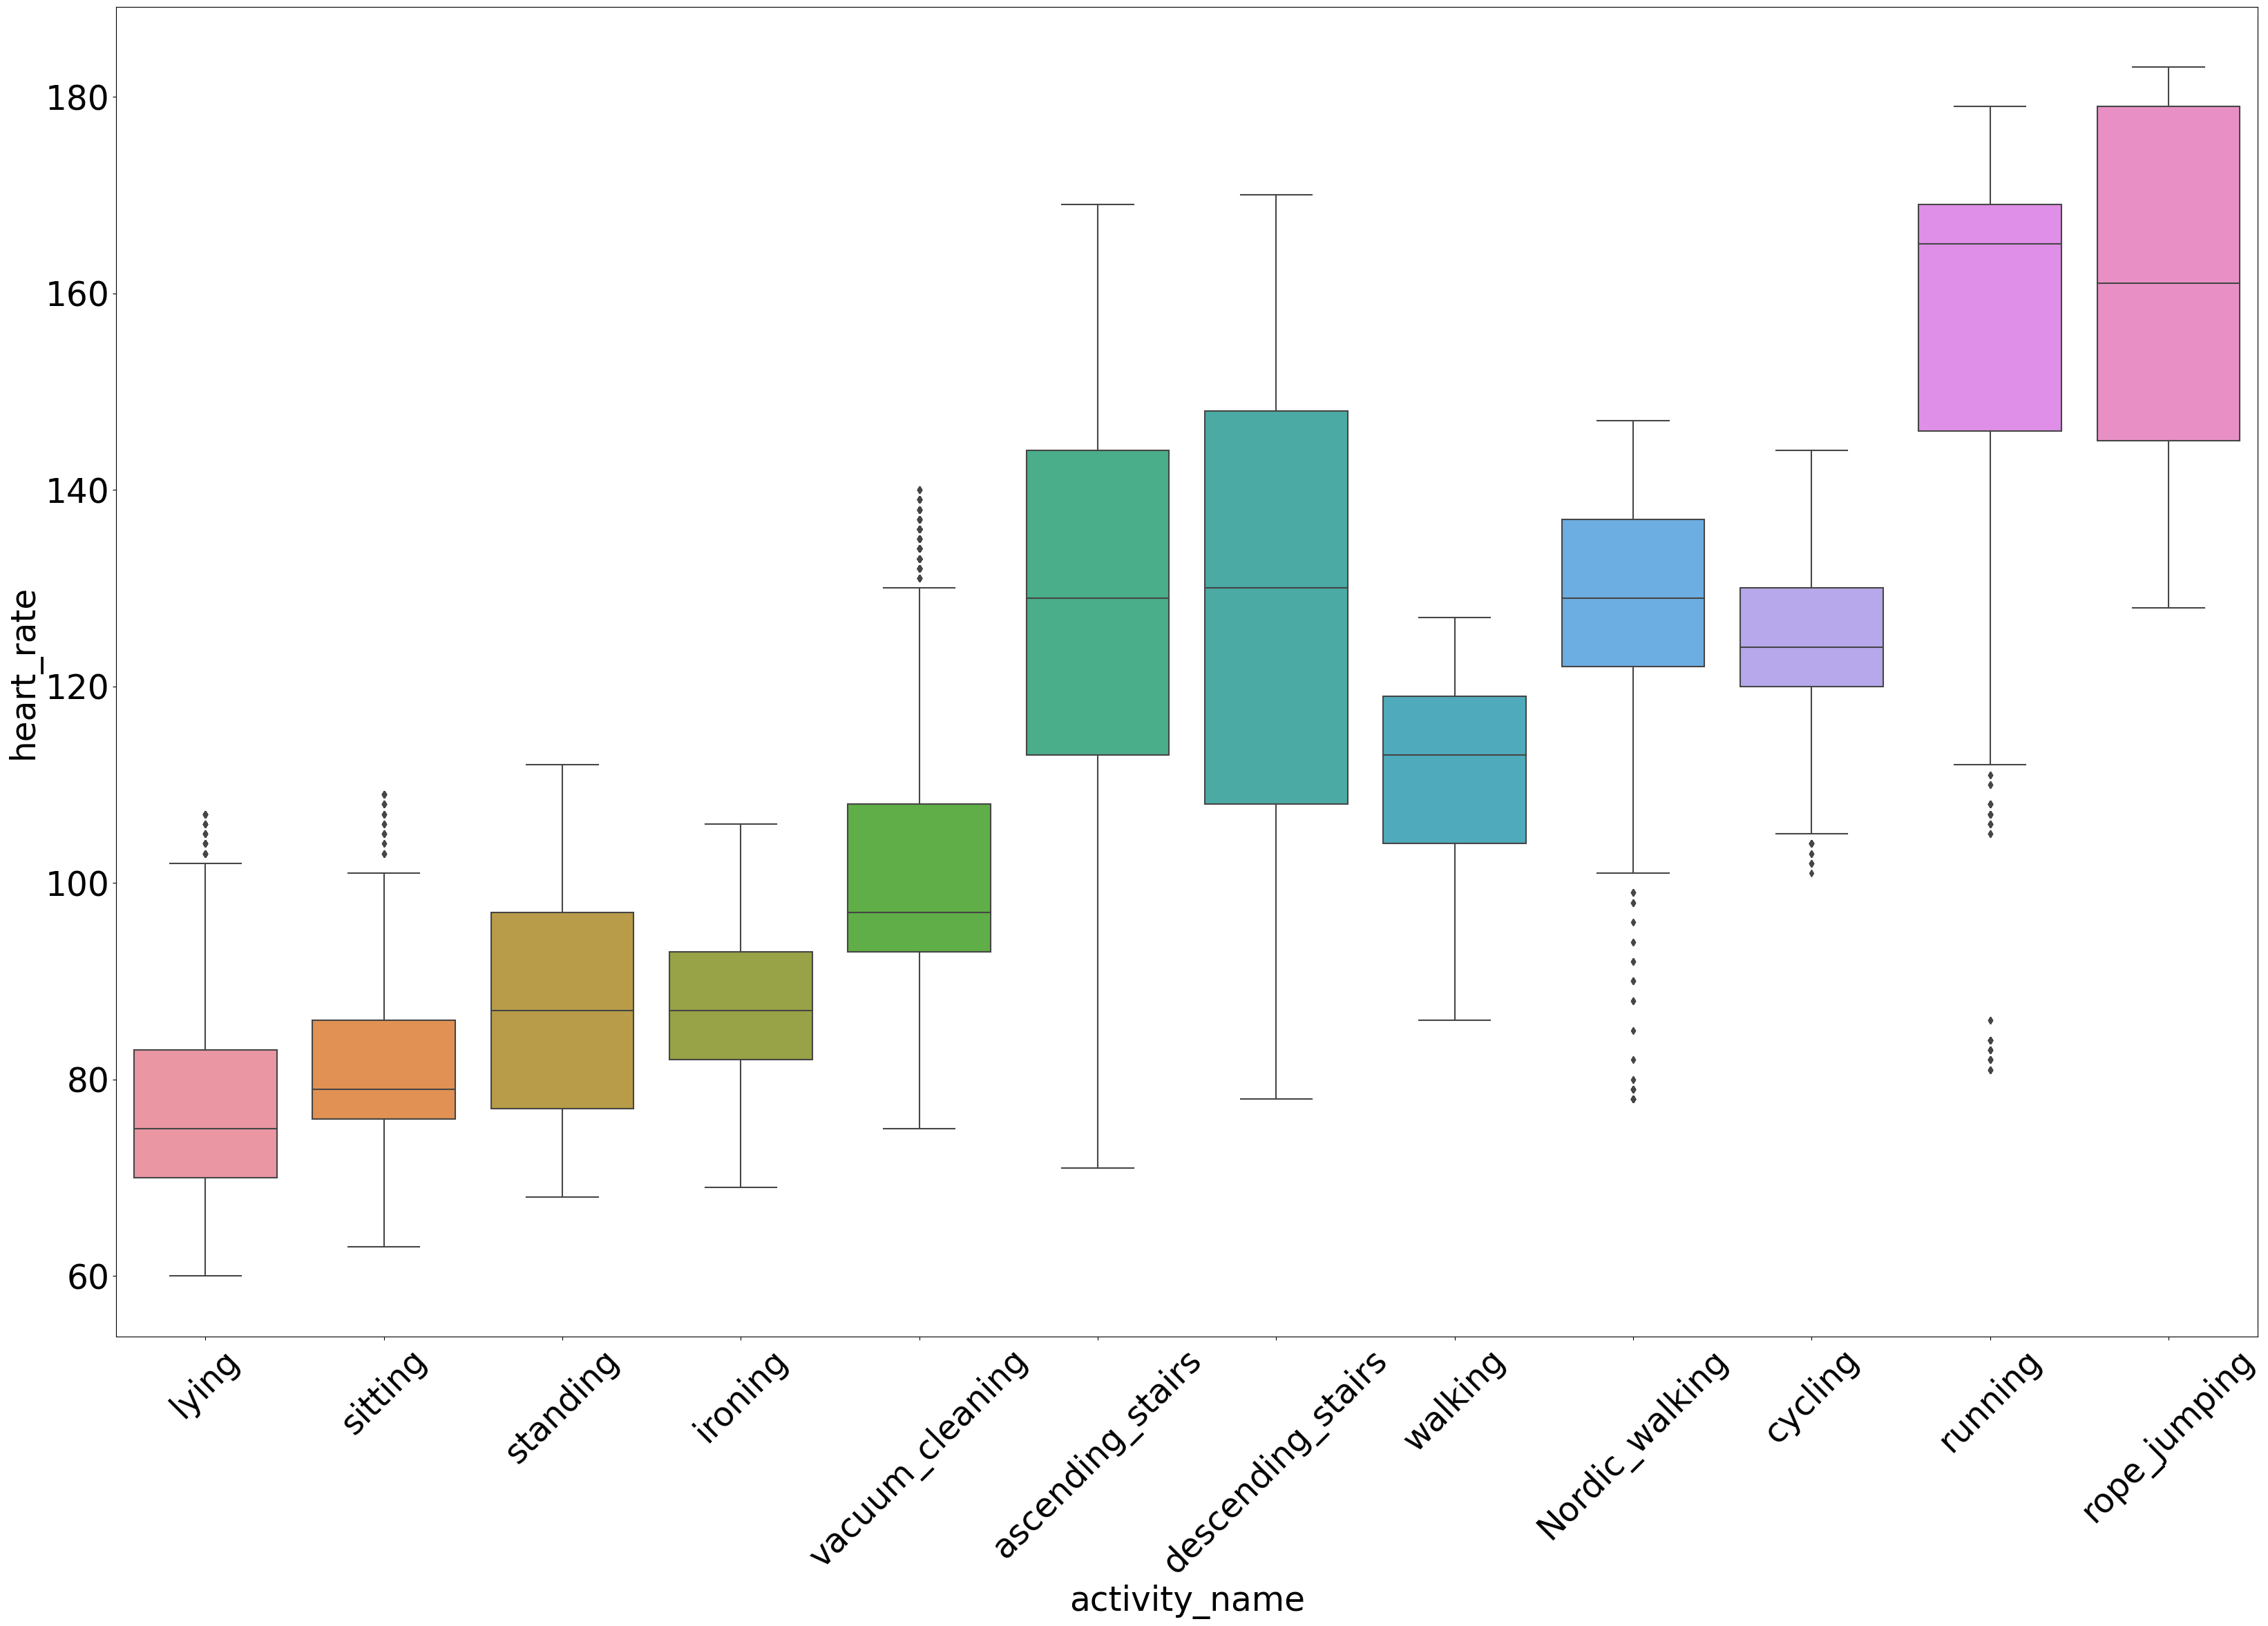

In [101]:
rcParams['figure.figsize'] = 40,25 # Setting the figure dimensions 
rcParams['font.size'] = 35 # Setting the text and number font size
ax=sns.boxplot(x="activity_name",y="heart_rate",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

  1. From the boxplot we can notice that activities like running and rope jumping have higher average heart rate than other activities<br>
  2. 'Nordic_walking' and 'running' have a lot of outliers on the lower side<br>
  3.  Activities like 'lying','sitting' and standing have a lot of outliers on the upper side.

* Boxplot of hand temperature grouped by activity

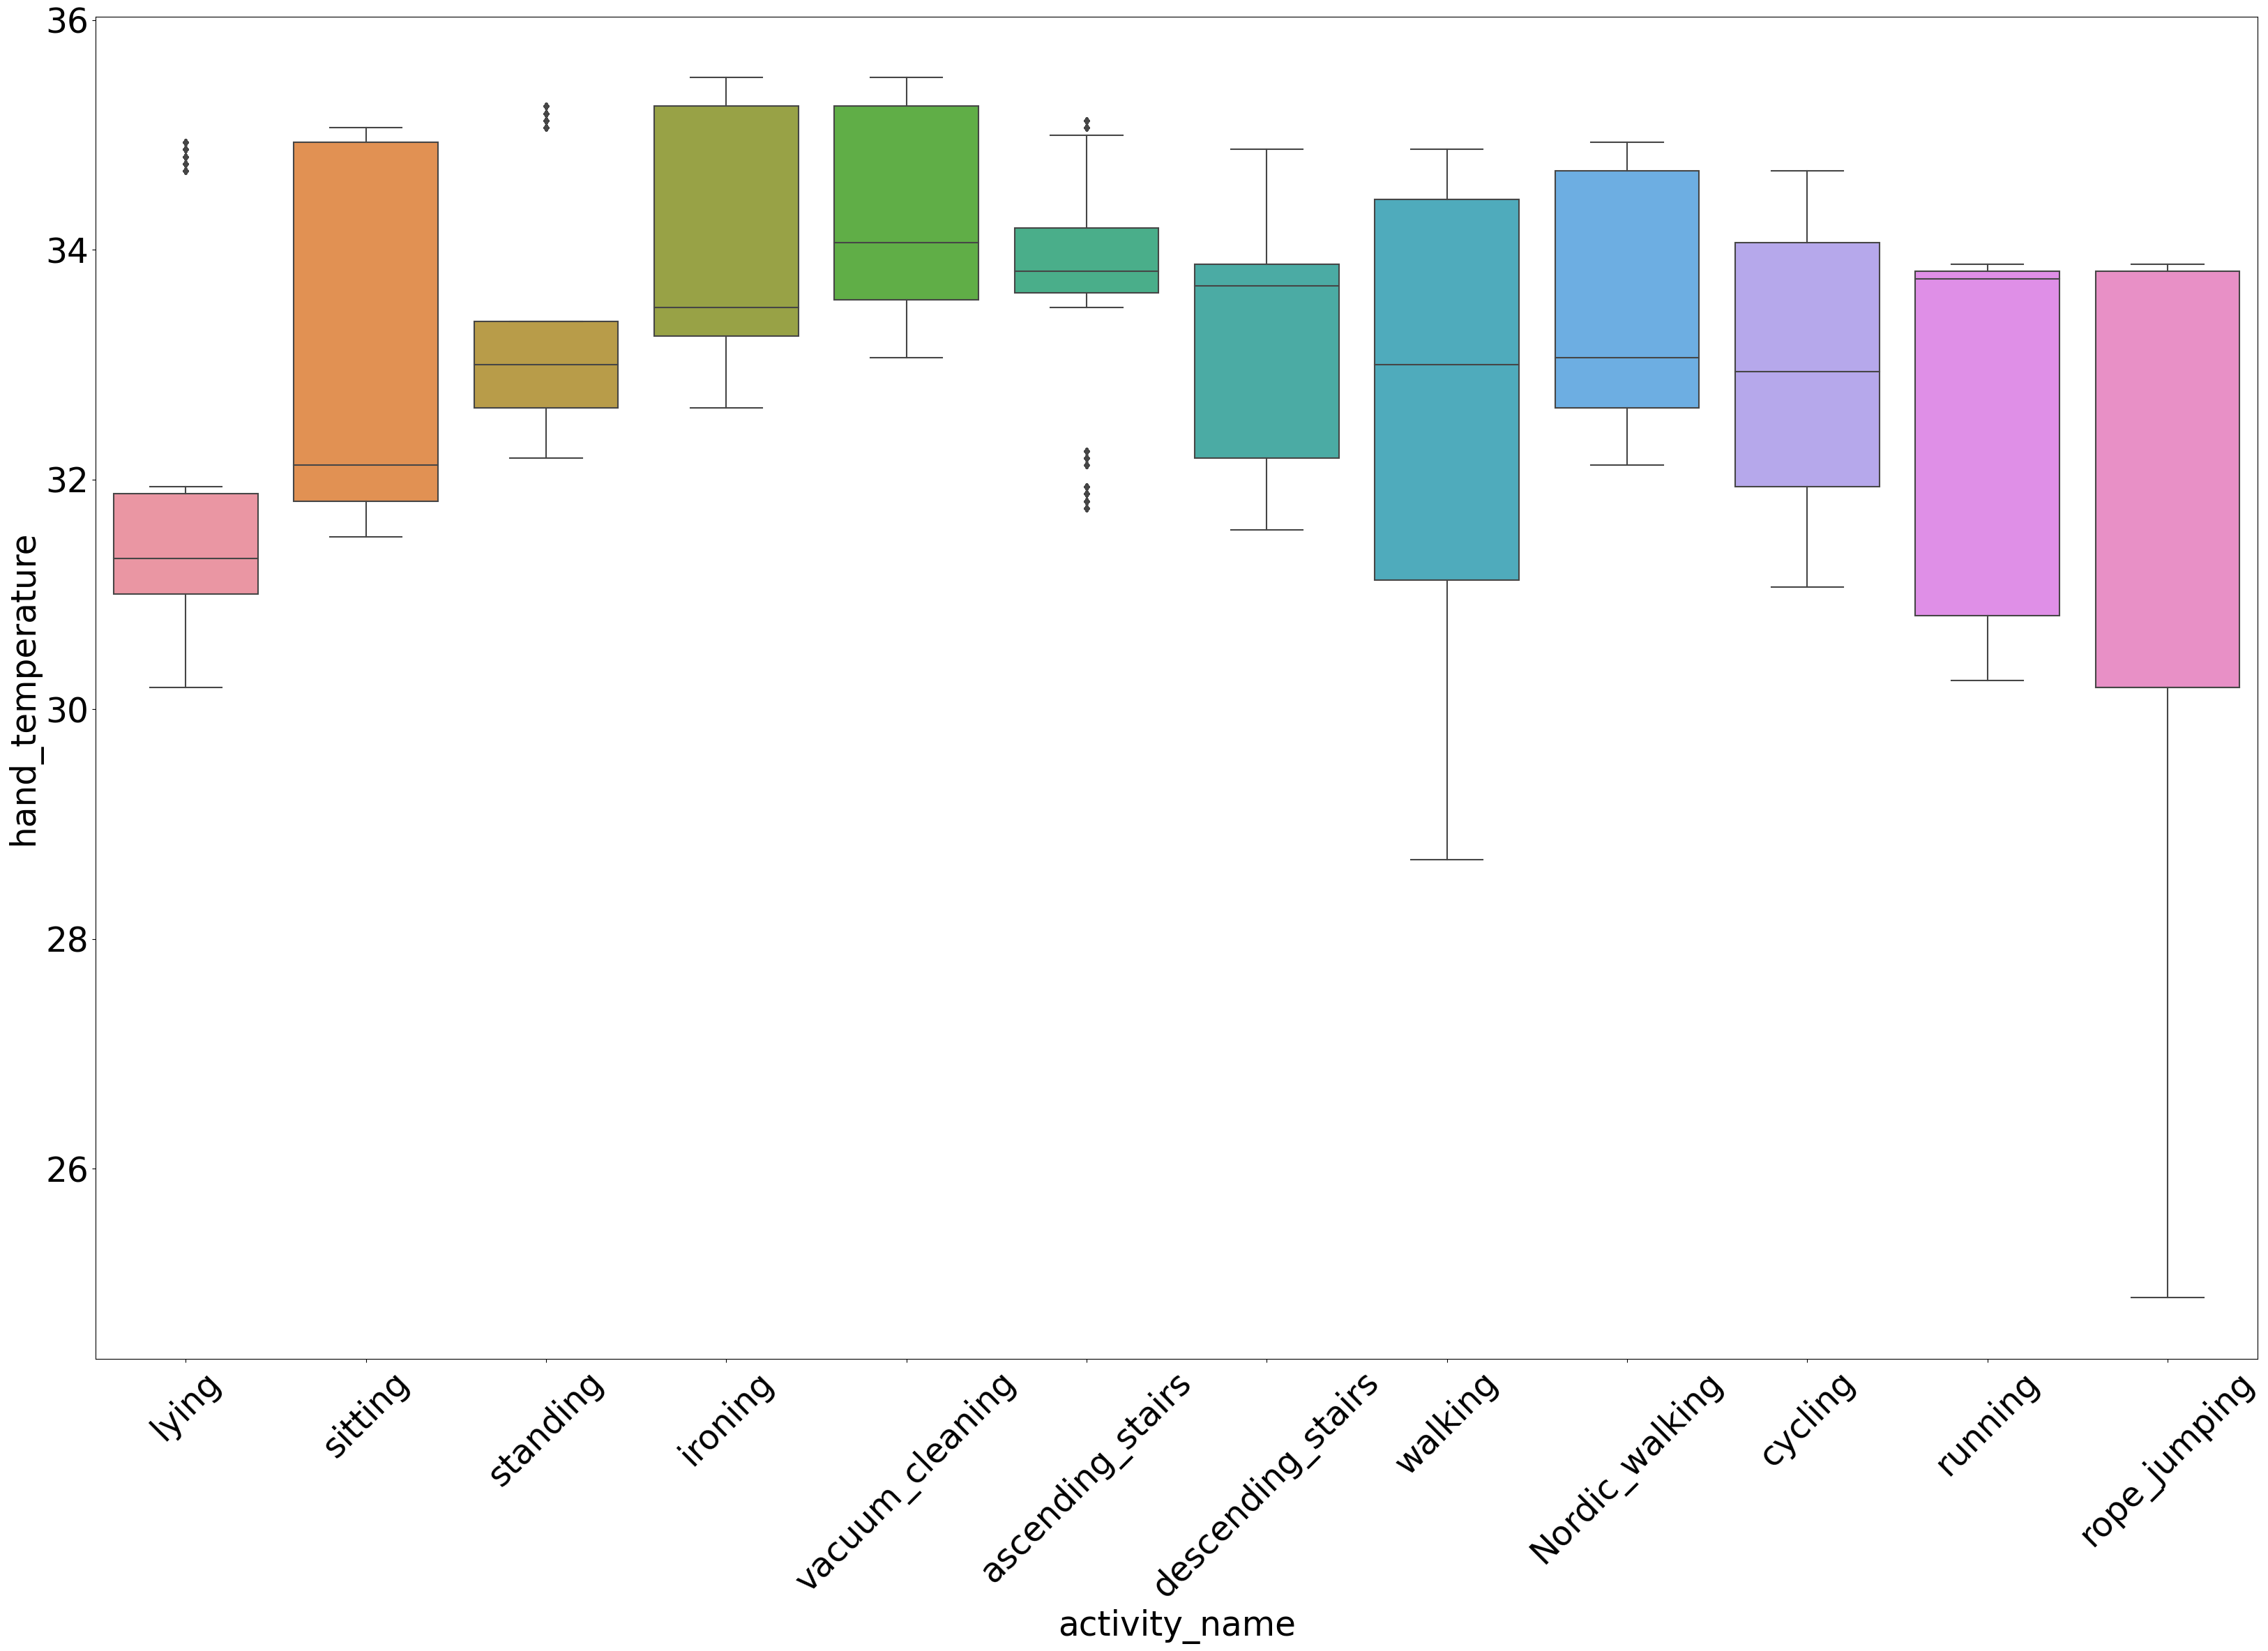

In [102]:
ax=sns.boxplot(x="activity_name",y="hand_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

1. "Ironing" and "vacuum_cleaning" may have higher average hand temperatures compared to other activitiies<br>
2. "Lying" and "standing" have outliers on the upper side while "ascending_stairs" has it on the lower side

* Boxplot of ankle temperature grouped by activity

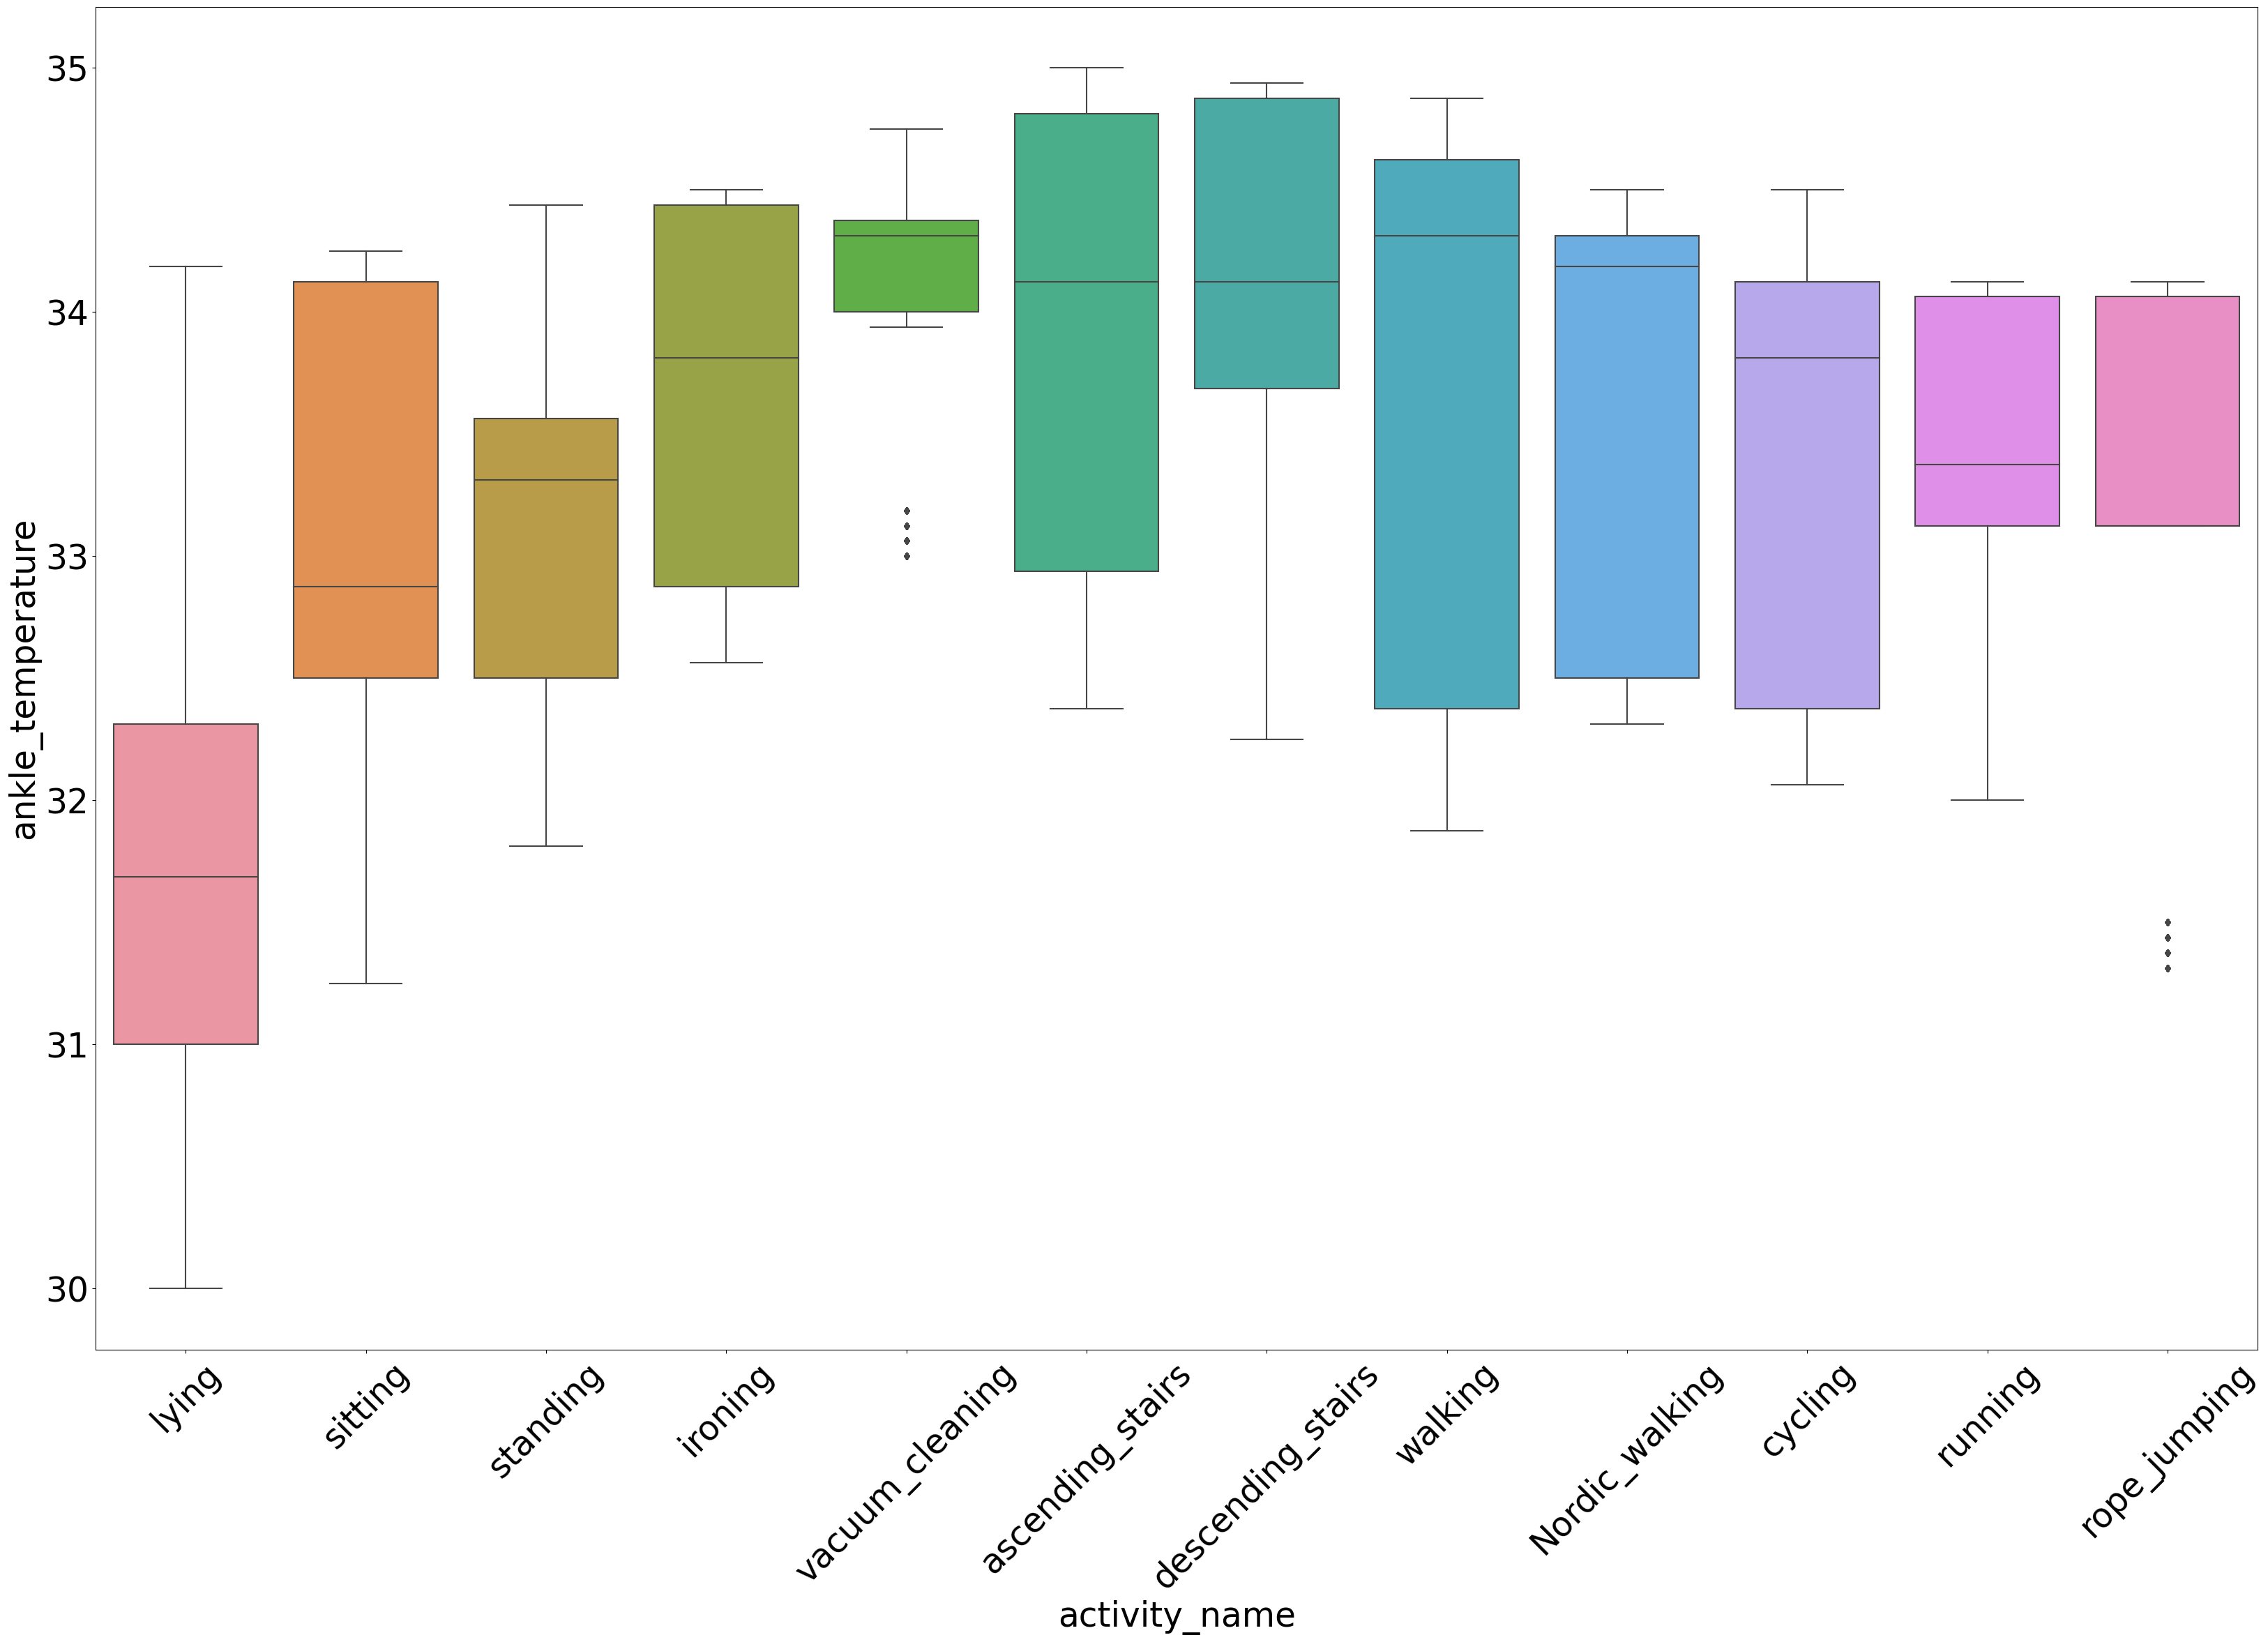

In [103]:
ax=sns.boxplot(x="activity_name",y="ankle_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. Interestingly, we see that ankle_temperature might be lower on average while lying.<br>
2. Outliers are mostly present in "rope_jumping" and "vacuum_cleaning" on the lower side. 

* Boxplot of chest temperature grouped by activity

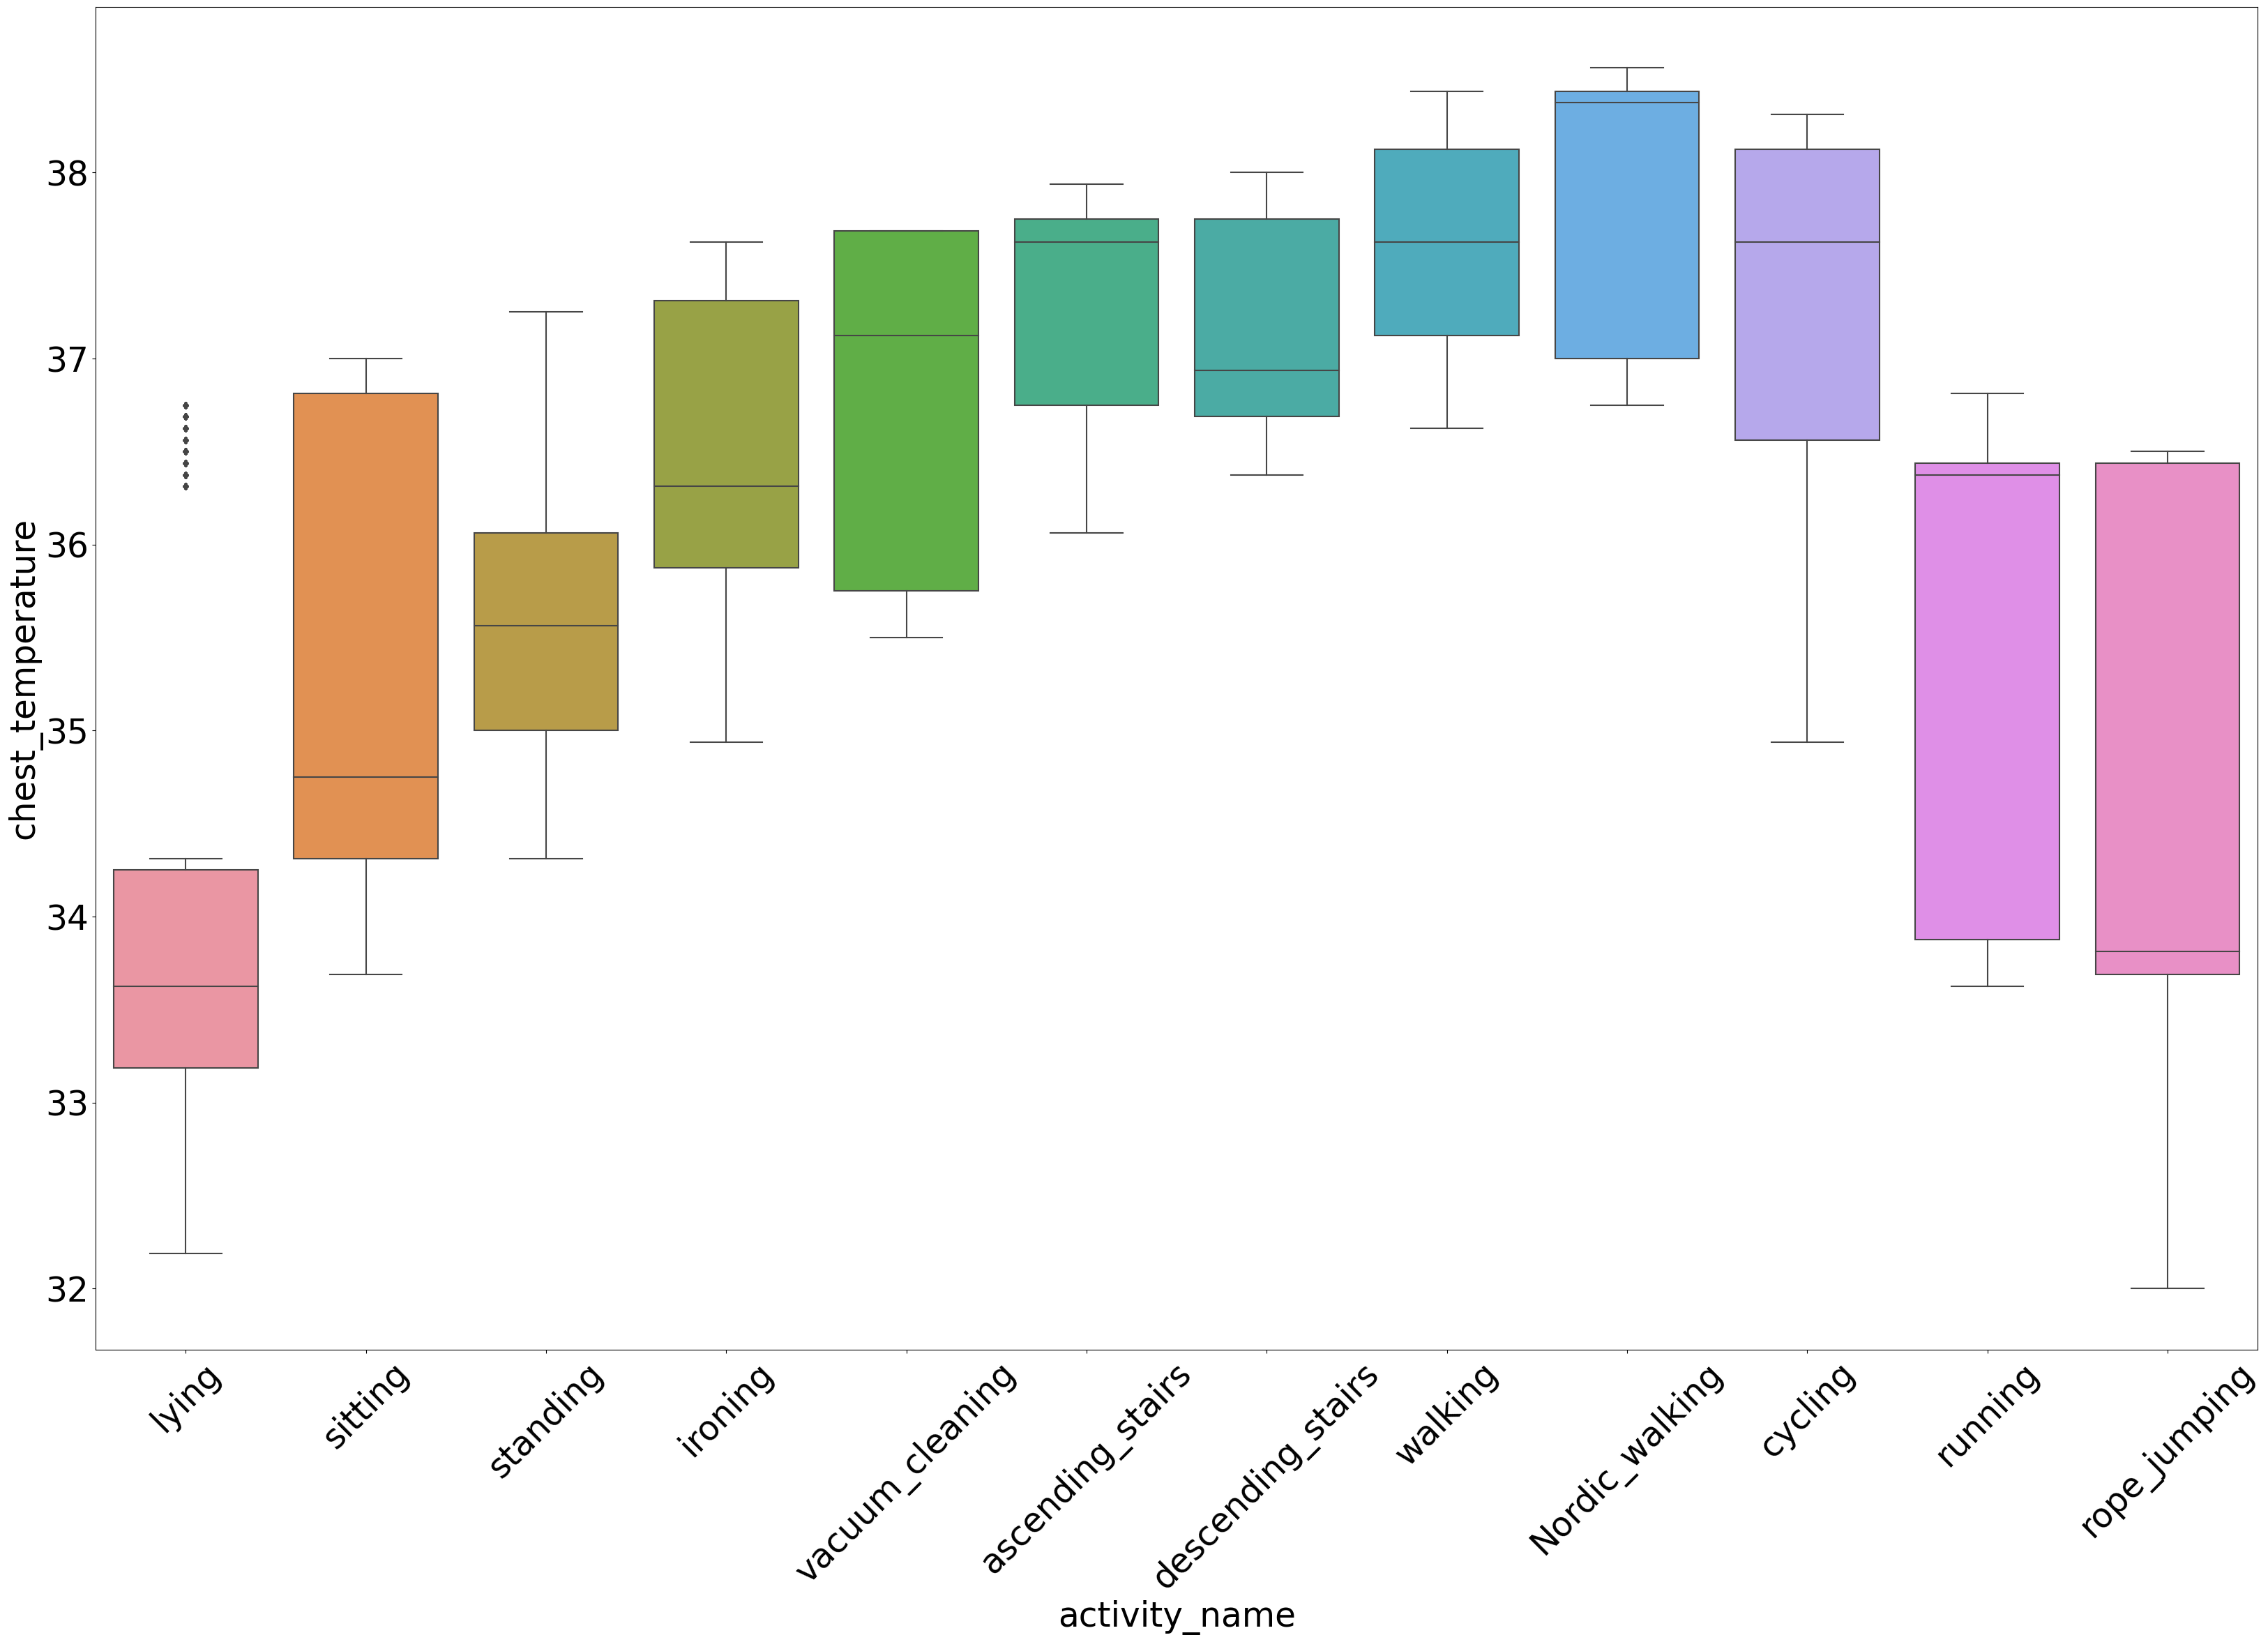

In [104]:
ax=sns.boxplot(x="activity_name",y="chest_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. Just like ankle temperature,the mean of chest temperature seems to be lower while lying  <br>
   and even "running" seems to have lower average, although the data is more widely distributed and positively skewed.<br>
2. The outliers are only present in "lying" and they are on the higher side.

* A joint plot trying to investigate possibility of correlation between heart rate <br>
  and chest temperature.

<Figure size 4000x2500 with 0 Axes>

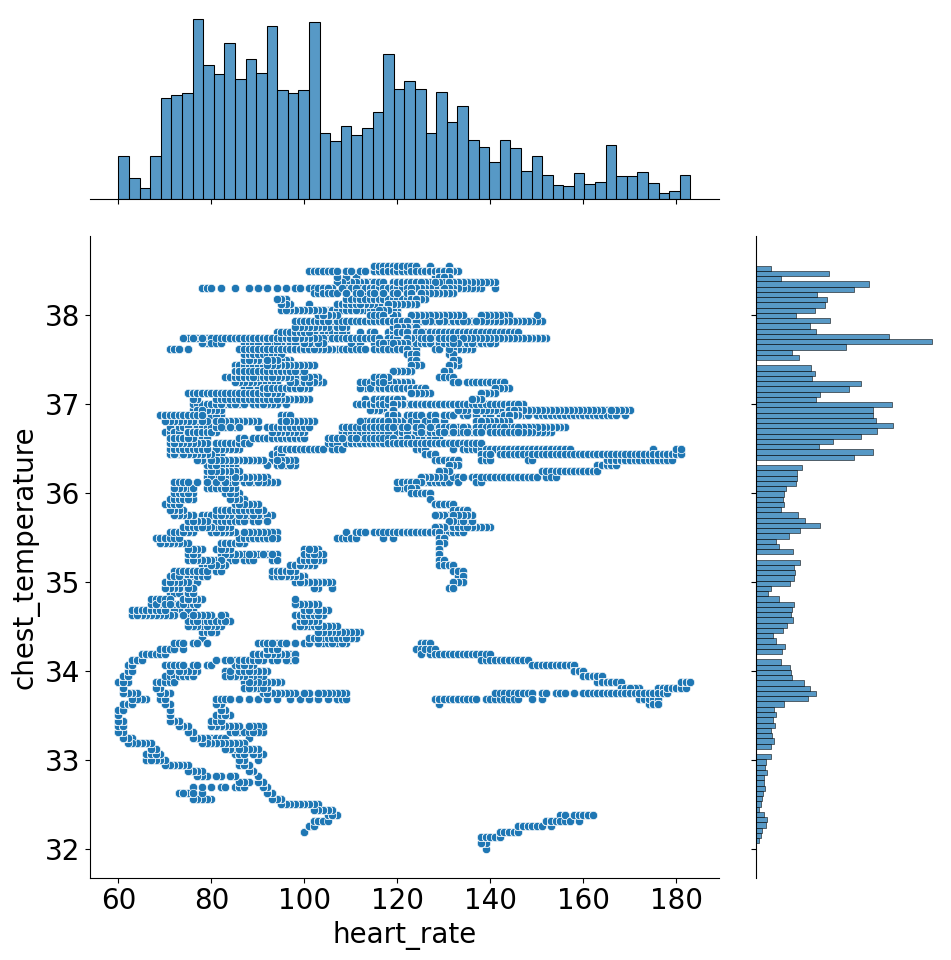

In [105]:
plt.clf()
rcParams['font.size'] = 20 # Setting the text and number font size
g = sns.JointGrid(data=train, x="heart_rate", y="chest_temperature",
                  height=10,ratio=3)
g.plot_joint(sns.scatterplot,palette='colorblind')
g.plot_marginals(sns.histplot)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. From the scatter plot, we see that there does not seem to be a correlation between<br>
   the two variables.<br>
2. The respective histograms indicate that both the features considered have <br>
   a multi-modal distribution

### Decriptive Statistics<br>
Mean of heart rate and temperatures for each activity

In [106]:
display(train.groupby(by='activity_name')[['heart_rate','chest_temperature','hand_temperature',
    'ankle_temperature']].mean())
discard = ['activity_id','activity','time_stamp','id']# Columns to exclude from descriptive statistics

,heart_rate,chest_temperature,hand_temperature,ankle_temperature
activity_name,,,,
Nordic_walking,128.428740,38.002287,33.468123,33.576507
ascending_stairs,128.129623,37.245243,33.749376,33.902398
cycling,124.643823,37.273081,32.944302,33.468345
descending_stairs,128.048666,37.216314,33.460880,33.976745
ironing,87.605263,36.394115,33.870391,33.732693
lying,76.431261,34.154954,32.022821,31.991473
rope_jumping,160.949593,34.174437,30.018546,32.999135
running,155.256545,35.374824,32.383314,33.524197
sitting,80.581110,35.201741,32.866760,32.972237


Creating table with only relevant columns

In [107]:
train_trimmed = train[[i for i in train.columns if i not in discard]]

Descriptive info of relevant feature

In [108]:
display(train_trimmed.describe())

,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,...,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z
count,42919.000000,465718.000000,465718.000000,465718.000000,465718.000000,465718.000000,465718.000000,465718.000000,465718.000000,465718.000000,...,466069.000000,466069.000000,466069.000000,466069.000000,466069.000000,466069.000000,466069.000000,466069.000000,466069.000000,466069.000000
mean,106.977795,33.086767,-4.531174,5.127693,3.691331,-4.453557,5.145602,3.869735,0.018210,0.028877,...,-2.871731,9.265277,0.020914,-2.487470,0.008675,-0.029342,0.018526,-33.990066,0.405375,17.530419
std,27.450855,1.577440,5.987985,5.735426,3.834510,6.000519,5.605228,3.823926,1.202815,0.869325,...,4.044718,6.230598,7.347707,3.700324,1.085426,0.650239,1.995012,21.394987,23.868478,21.524144
min,60.000000,24.875000,-84.937200,-70.652900,-38.907800,-61.193800,-58.959800,-35.489600,-27.804400,-7.428840,...,-158.830000,-51.532900,-61.903500,-62.289300,-13.385600,-7.807450,-14.019600,-172.865000,-137.908000,-102.716000
25%,85.000000,32.187500,-8.792060,2.546965,1.279535,-8.688758,2.599390,1.490622,-0.354895,-0.211693,...,-4.200580,8.366750,-2.299260,-3.825880,-0.218214,-0.120351,-0.473103,-45.265500,-14.108400,3.764310
50%,102.000000,33.125000,-4.542280,4.525005,3.474010,-4.438570,4.538715,3.718865,-0.003983,0.007901,...,-2.649760,9.529390,-0.229827,-2.275680,0.004239,-0.003763,-0.004165,-34.933100,-0.241023,19.076600
75%,125.000000,34.187500,-0.164173,7.353377,6.453197,-0.035227,7.385640,6.703340,0.327368,0.262643,...,-1.137170,10.193900,1.661840,-0.708760,0.110471,0.133649,0.073709,-16.218000,18.923300,32.000000
max,183.000000,35.500000,47.631400,155.257000,76.639600,32.067800,62.259800,52.710700,26.415800,13.172700,...,151.510000,61.947200,62.033000,60.935700,13.142500,6.410380,14.482700,89.276100,94.247800,121.814000


Correlation table of relevant features

In [109]:
display(train_trimmed.corr()) 

,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,...,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z
heart_rate,1.000000,-0.120277,-0.263541,0.143499,-0.208032,-0.266851,0.148047,-0.211438,0.037539,0.045708,...,-0.013507,0.310142,0.293326,-0.009329,0.000837,-0.015337,0.004026,-0.348762,-0.364626,-0.066593
hand_temperature,-0.120277,1.000000,-0.086164,-0.017679,-0.015067,-0.074615,-0.019069,0.000030,-0.028327,0.002643,...,-0.009558,0.093842,0.044073,-0.003462,0.001832,-0.003518,-0.000395,0.007314,0.073550,0.185585
hand_3D_acceleration_16_x,-0.263541,-0.086164,1.000000,-0.058393,0.141919,0.983205,-0.076604,0.134984,0.032232,-0.040163,...,-0.015641,-0.320184,-0.136253,-0.020200,0.054043,-0.021825,0.152219,0.060292,0.270670,-0.058987
hand_3D_acceleration_16_y,0.143499,-0.017679,-0.058393,1.000000,0.038482,-0.053878,0.921966,0.026495,0.162128,-0.035331,...,-0.033934,0.043614,0.125343,-0.037680,0.024108,-0.046379,-0.030699,-0.056327,-0.040182,-0.002373
hand_3D_acceleration_16_z,-0.208032,-0.015067,0.141919,0.038482,1.000000,0.149177,0.001509,0.966732,-0.011123,0.022992,...,0.003772,-0.142394,-0.074129,0.003461,0.047157,0.023105,0.038695,0.055526,0.116986,-0.025542
hand_3D_acceleration_6_x,-0.266851,-0.074615,0.983205,-0.053878,0.149177,1.000000,-0.073845,0.140515,0.025530,-0.019407,...,-0.012802,-0.314940,-0.134206,-0.017179,0.055022,-0.030648,0.131911,0.059964,0.276850,-0.055430
hand_3D_acceleration_6_y,0.148047,-0.019069,-0.076604,0.921966,0.001509,-0.073845,1.000000,0.025198,0.114433,-0.041382,...,-0.036756,0.036685,0.133908,-0.040391,0.024726,-0.040662,-0.009122,-0.058922,-0.041997,-0.001701
hand_3D_acceleration_6_z,-0.211438,0.000030,0.134984,0.026495,0.966732,0.140515,0.025198,1.000000,-0.003813,-0.002641,...,0.002621,-0.143587,-0.073105,0.002020,0.047295,0.026062,0.045100,0.054857,0.120797,-0.024483
hand_3D_gyroscope_x,0.037539,-0.028327,0.032232,0.162128,-0.011123,0.025530,0.114433,-0.003813,1.000000,-0.313286,...,-0.021268,0.028554,-0.000810,-0.025993,-0.010879,-0.048151,0.107464,0.017959,-0.055237,-0.008017
hand_3D_gyroscope_y,0.045708,0.002643,-0.040163,-0.035331,0.022992,-0.019407,-0.041382,-0.002641,-0.313286,1.000000,...,-0.002470,0.031211,0.023513,-0.001592,0.070738,0.040240,-0.032723,-0.027570,-0.019718,-0.009230


## Hypothesis Testing  

Based on the exploratory data analysis carried out, the folloeing hypotheses are tested on  <br>
the test set:<br>
- Hand temperature is higher during 'ironing' and 'vaccum_cleaning' compared<br>
  to other activities.<br>
- Ankle temperature is lower than other activities while lying.<br>
- Chest temperature is lower while lying compared to other activities. 

Based on the EDA  we performed, it does not seem that the data is normally distributed. It is <br>
for this reason that Wilcoxon rank sum test was used to test the above hypothesis instead of the usual t-test whcih assumes that the samples follow a normal distribution.<br>
We test the above hypothesis using the confidence level of 5%.

$H_0$(Null) : The hand temperature while ironing and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The hand temperature while ironing is likely to be higher compared to other activities.

In [110]:
test1 = test[test.activity_name=='ironing'].hand_temperature
test2 = test[test.activity_name!='ironing'].hand_temperature
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=124.34915850398421, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The hand temperature while 'vacuum_cleaning' and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The hand temperature while 'vacuum_cleaning' is likely to be higher compared to other activities.

In [111]:
test1 = test[test.activity_name=='vacuum_cleaning'].hand_temperature
test2 = test[test.activity_name!='vacuum_cleaning'].hand_temperature
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=161.77566662125983, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The ankle temperature while lying and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The ankle temperature while lying is likely to be lower compared to other activities.

In [112]:
test1 = test[test.activity_name=='lying'].ankle_temperature
test2 = test[test.activity_name!='lying'].ankle_temperature
print(ranksums(test1,test2,alternative='less'))

RanksumsResult(statistic=-250.1495175321391, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The chest temperature while lying and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The chest temperature while lying is likely to be lower compared to other activities.

In [113]:
test1 = test[test.activity_name=='lying'].chest_temperature
test2 = test[test.activity_name!='lying'].chest_temperature
print(ranksums(test1,test2,alternative='less'))

RanksumsResult(statistic=-286.0169458281912, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 